In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [4]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HealthCare/hungary_chickenpox.csv')
df_main.head()

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60


In [5]:
df_main.shape

(522, 21)

In [6]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      522 non-null    object
 1   BUDAPEST  522 non-null    int64 
 2   BARANYA   522 non-null    int64 
 3   BACS      522 non-null    int64 
 4   BEKES     522 non-null    int64 
 5   BORSOD    522 non-null    int64 
 6   CSONGRAD  522 non-null    int64 
 7   FEJER     522 non-null    int64 
 8   GYOR      522 non-null    int64 
 9   HAJDU     522 non-null    int64 
 10  HEVES     522 non-null    int64 
 11  JASZ      522 non-null    int64 
 12  KOMAROM   522 non-null    int64 
 13  NOGRAD    522 non-null    int64 
 14  PEST      522 non-null    int64 
 15  SOMOGY    522 non-null    int64 
 16  SZABOLCS  522 non-null    int64 
 17  TOLNA     522 non-null    int64 
 18  VAS       522 non-null    int64 
 19  VESZPREM  522 non-null    int64 
 20  ZALA      522 non-null    int64 
dtypes: int64(20), ob

In [7]:
df = df_main[['Date','BUDAPEST']]
df = df[df['BUDAPEST'] > 0]
df.reset_index(inplace=True,drop=True)

In [8]:
time = pd.date_range(start='1/3/2005',periods=521,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [9]:
df.min()

BUDAPEST    2
dtype: int64

In [10]:
df.head()

,BUDAPEST
time_stamp,
2005-01-09,168
2005-01-16,157
2005-01-23,96
2005-01-30,163
2005-02-06,122


In [11]:
df.tail()

,BUDAPEST
time_stamp,
2014-11-30,95
2014-12-07,43
2014-12-14,35
2014-12-21,30
2014-12-28,259


In [12]:
plt.rcParams['figure.figsize'] = [15,8]

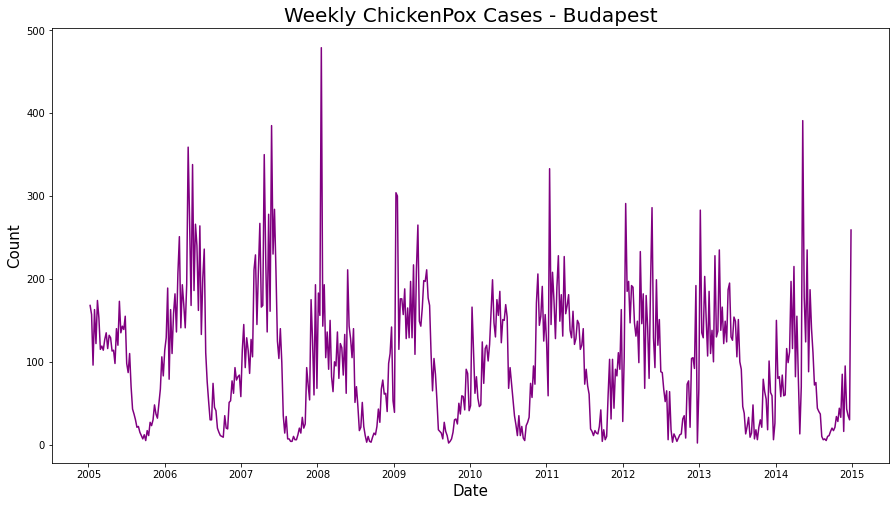

In [13]:
plt.plot(df,color='purple')
plt.title('Weekly ChickenPox Cases - Budapest',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [14]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [46]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['BUDAPEST'] = df['BUDAPEST'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [47]:
#Split data set into testing dataset and train dataset
train_size = 469
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [32]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(466, 1, 3)
(466,)
(49, 1, 3)
(49,)


In [18]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.3 MB/s 


In [19]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer_1',min_value=16,max_value=256,step=16), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(hp.Int(f'rnn_{i}_units',min_value=16,max_value=256,step=16),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice(f"recurrent_dropout_{i}",[0.2,0.4,0.6],default=0.4)))
    model.add(LSTM(hp.Int('final_rnn_layer',min_value=16,max_value=256,step=16),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(Dense(hp.Int(f'rnn_{i}_units',min_value=16,max_value=256,step=16),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_5')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
rnn_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
recurrent_dropout_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{

In [ ]:
tuner.search(trainX, trainY,
             epochs=500,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 03m 29s]
val_mae: 0.06653515994548798

Best val_mae So Far: 0.06653515994548798
Total elapsed time: 00h 32m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_5
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
rnn_layer_1: 240
first_recurrent_dropout: 0.4
n_layers: 1
rnn_0_units: 112
recurrent_dropout_0: 0.6
final_rnn_layer: 64
last_recurrent_dropout: 0.6
Dropout_rate: 0.2
learning_rate: 0.05362080935202371
rnn_1_units: 176
recurrent_dropout_1: 0.6
Score: 0.06653515994548798
Trial summary
Hyperparameters:
rnn_layer_1: 48
first_recurrent_dropout: 0.4
n_layers: 2
rnn_0_units: 160
recurrent_dropout_0: 0.2
final_rnn_layer: 256
last_recurrent_dropout: 0.2
Dropout_rate: 0.4
learning_rate: 0.005578816564959981
rnn_1_units: 80
recurrent_dropout_1: 0.2
Score: 0.06681305170059204
Trial summary
Hyperparameters:
rnn_layer_1: 224
first_recurrent_dropout: 0.2
n_layers: 1
rnn_0_units: 208
recurrent_dropout_0: 0.6
final_rnn_layer: 80
last_recurrent_dropout: 0.4
Dropout_rate: 0.4
learning_rate: 0.008293061225099728
rnn_1_units: 80
recurrent_dropout_1: 0.6
Score: 0.06695

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 240)            234240    
                                                                 
 lstm_1 (LSTM)               (None, 1, 112)            158144    
                                                                 
 lstm_2 (LSTM)               (None, 64)                45312     
                                                                 
 dense (Dense)               (None, 112)               7280      
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 113       
                                                                 
Total params: 445,089
Trainable params: 445,089
Non-trai

In [20]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [48]:
model = Sequential()
model.add(Bidirectional(LSTM(64,activation='relu',input_dim = 3,return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(8,activation='relu')))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00009362080935202371)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 500)

Epoch 1/500
13/13 [==============================] - 8s 81ms/step - loss: 0.2890 - mae: 0.2890 - val_loss: 0.2496 - val_mae: 0.2496
Epoch 2/500
13/13 [==============================] - 0s 9ms/step - loss: 0.2865 - mae: 0.2865 - val_loss: 0.2472 - val_mae: 0.2472
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 0.2840 - mae: 0.2840 - val_loss: 0.2448 - val_mae: 0.2448
Epoch 4/500
13/13 [==============================] - 0s 9ms/step - loss: 0.2815 - mae: 0.2815 - val_loss: 0.2422 - val_mae: 0.2422
Epoch 5/500
13/13 [==============================] - 0s 9ms/step - loss: 0.2788 - mae: 0.2788 - val_loss: 0.2396 - val_mae: 0.2396
Epoch 6/500
13/13 [==============================] - 0s 9ms/step - loss: 0.2761 - mae: 0.2761 - val_loss: 0.2368 - val_mae: 0.2368
Epoch 7/500
13/13 [==============================] - 0s 10ms/step - loss: 0.2732 - mae: 0.2732 - val_loss: 0.2339 - val_mae: 0.2339
Epoch 8/500
13/13 [==============================] - 0s 9ms/step - loss: 0.2702 -

In [22]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [49]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

Train MAE: 33.69946827633155
Test MAE: 38.29129067210158


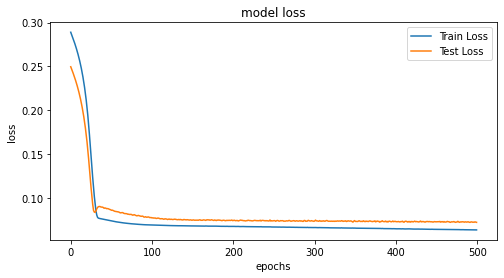

In [50]:
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [28]:
import seaborn as sns

In [26]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(466,515)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

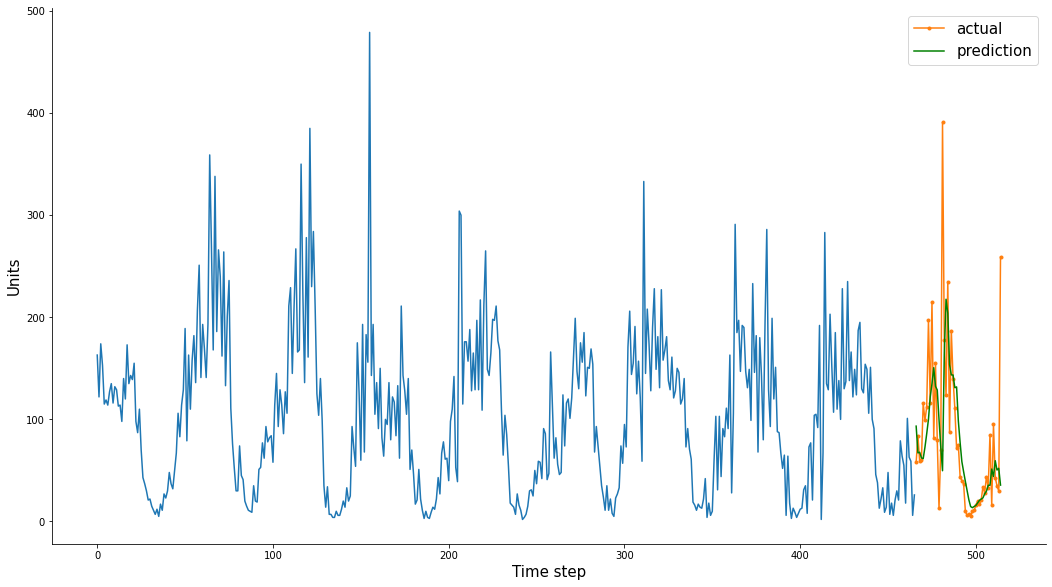

In [51]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)